# Distributed computing: dask and zarr

Dask is a library that implements (among other things) object equivalent to Numpy arrays and Pandas dataframes but designed for data that are too large for memory. A general strategy in such cases is to split the objects into multiple pieces. Zarr is a modern data format that allows to save such split objects locally or in the cloud.

## dask arrays

Dask implements array very similar to Numpy:

In [ ]:
import dask.array as da

In [60]:
dask_array = da.random.randint(0,100, (1000,1000), chunks=(500,500))

In [61]:
dask_array

dask.array<randint, shape=(1000, 1000), dtype=int64, chunksize=(500, 500), chunktype=numpy.ndarray>

In [62]:
dask_array.shape

(1000, 1000)

The specificity is that his array is split into chunks. Whenever we want to do a computation, dask will try to optimize it so that computation is done in parallel and on separate chunks. For example we can try to compute the mean of the array:

In [63]:
mean_val = dask_array.mean()

In [64]:
mean_val

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

If we print the result we don't see the result, but the exepcted type of output. We can however check how dask plans to do this computation:

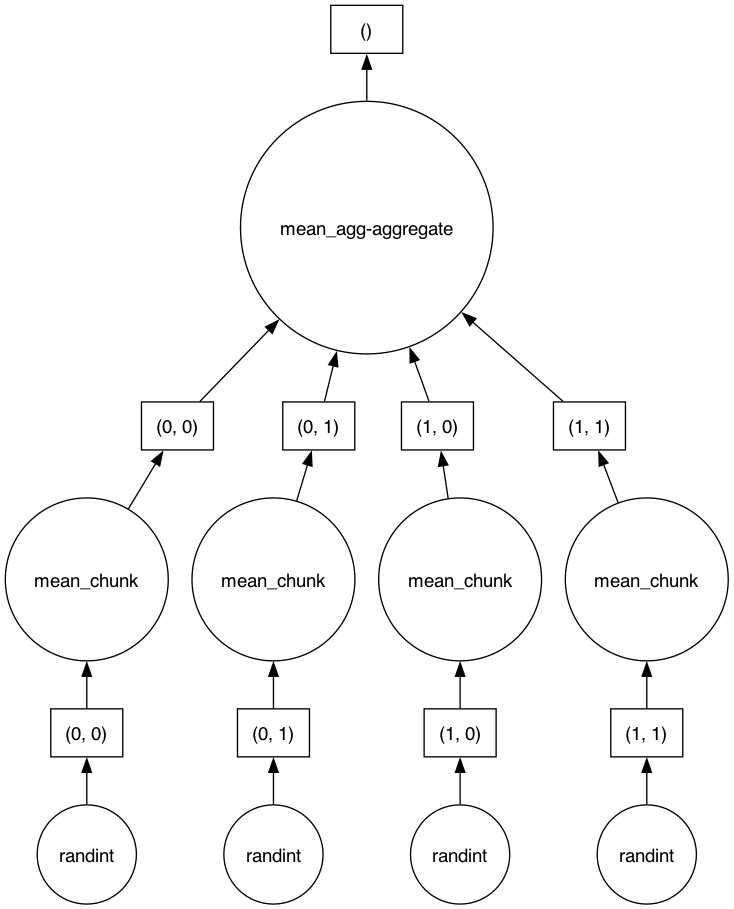

In [65]:
mean_val.visualize()

Here mean of each chunk is computed separately and then combined with the other results to give us the final answer. In case the entire dataset cannot be loaded in memory we can still compute this value!

In [66]:
mean_val.compute()

49.488425

Similar structures exist e.g. for dataframes.

## Importing data from the cloud

We can diretly store very large data in chunked format allowing to efficiently load data and perform computations on them using dask. Zarr is a modern format that implements such chunking. Here 's some data that is stored in the cloud and that we can attempt to load (it could be stored locally as well):

In [67]:
import s3fs
import zarr

s3 = s3fs.S3FileSystem(anon=True, endpoint_url='https://os.zhdk.cloud.switch.ch') 
store = s3fs.S3Map(root='sediment/HL_30-40/HL4_30-31_220726-172331/capture/HL4_30-31_220726-172331.zarr', s3=s3, check=False)
dataset = zarr.open(store, mode='r')

In [68]:
dataset

<zarr.core.Array (392, 13044, 1312) uint16 read-only>

IF we look at ```dataset``` we see that it is again a type of array. It behaves very similarly to a Numpy array. The difference here is that it wasn't downloaded: we can just download the pieces we need. We can get more informatio on the array:

In [69]:
dataset.info

Type,zarr.core.Array
Data type,uint16
Shape,"(392, 13044, 1312)"
Chunk shape,"(1, 2000, 1312)"
Order,C
Read-only,True
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.FSStore
No. bytes,13417162752 (12.5G)
No. bytes stored,8087514026 (7.5G)
Storage ratio,1.7


The dataset is actually split into 2744 pices. The full size if 12Gb which would take quite a while to download. Here we can just download part of it:

In [70]:
single_plane = dataset[100,:,:]

In [71]:
import matplotlib.pyplot as plt

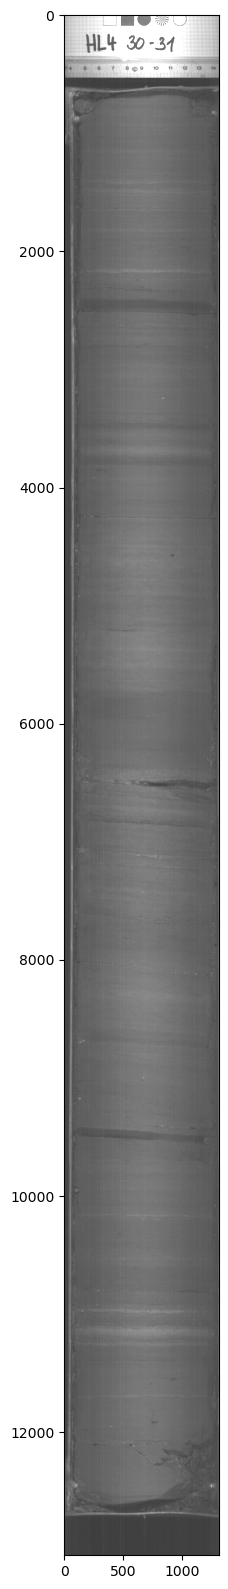

In [72]:
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(single_plane, cmap='gray', vmin=0, vmax=2000);

Furthermore, we could directly load this dataset as a dask array to perform efficient computing:

In [73]:
dask_array = da.from_zarr(store)

In [74]:
dask_array

dask.array<from-zarr, shape=(392, 13044, 1312), dtype=uint16, chunksize=(1, 2000, 1312), chunktype=numpy.ndarray>